# Programmatic access to the MICrONS dataset using CAVE

This tutorial walks through the key functions needed to access the MICrONS dataset programmatically and highlights key resources within it. While this tutorial is written for the MICrONS dataset specifically, the underlying technology (CAVE) is being used for multiple connectomics dataset. So, the interface presented here can be used to query them as well. 

## CAVEclient and setup

The CAVEclient is a python library that facilitates communication with a CAVE system. It can be install with

In [1]:
# !pip install caveclient

and imported like so:

In [2]:
import caveclient

## CAVE account setup

In order to manage server traffic, every user needs to create a CAVE account and download a user token to access CAVE's services programmatically. The CAVE infrastructure can be read about in more detail on our preprint. The MICrONS data is publicly available which means that no extra permissions need to be given to a new user account to access the data. Bulk downloads of some static data are also available without an account on MICrONs Explorer.

__A Google account (or Google-enabled account) is required to create a CAVE account.__

Go to: https://global.daf-apis.com/auth/api/v1/user/token to view a list of your existing tokens

If you have never made a token before:
1. go here: https://minnie.microns-daf.com/materialize/views/datastack/minnie65_public to accept terms of service
2. then go here https://global.daf-apis.com/auth/api/v1/create_token to create a new token.

### Set or save your token

From the website that just opened up, paste your token here:

In [3]:
my_token = "PASTE_TOKEN_HERE"

If you are running this on your local machine or on a server you can (optionally) store the token on your machine. This makes future uses easier.

In [4]:
# client.auth.save_token(token=my_token, overwrite=True)

## Libraries for this notebook

This notebook makes use of a few python libraries. These can be install via `pip install` in the command line or directly here:

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

## Initialize CAVEclient with a datastack

Datasets in CAVE are organized as datastacks. These are a combination of an EM dataset, a segmentation and a set of annotations. The datastack for MICrONS public release is `minnie65_public`. When you instantiate your client with this datastack, it loads all relevant information to access it.

In [6]:
datastack_name = "minnie65_public"

client = caveclient.CAVEclient(datastack_name, auth_token=my_token)

## Materialization versions


Data in CAVE is timestamped and periodically versioned - each (materialization) version corresponds to a specific timestamp. Individual versions are made publicly available. The materialization service provides annotation queries to the dataset. It is available under `client.materialize`. 

Currently the following versions are publicly available:

In [7]:
client.materialize.get_versions()

[1300, 1078, 117, 661, 343, 1181, 795, 943]

And these are their associated timestamps (all timestamps are in UTC):

In [8]:
for version in client.materialize.get_versions():
    print(f"Version {version}: {client.materialize.get_timestamp(version)}")

Version 1300: 2025-01-13 10:10:01.286229+00:00
Version 1078: 2024-06-05 10:10:01.203215+00:00
Version 117: 2021-06-11 08:10:00.215114+00:00
Version 661: 2023-04-06 20:17:09.199182+00:00
Version 343: 2022-02-24 08:10:00.184668+00:00
Version 1181: 2024-09-16 10:10:01.121167+00:00
Version 795: 2023-08-23 08:10:01.404268+00:00
Version 943: 2024-01-22 08:10:01.497934+00:00


The client will automatically query the latest materialization version. You can specify a `materialization_version` for every query if you want to access a specific version.

In [9]:
# for today we will use v1300
client.version = 1300

## Tables and generally useful information

A datastack has a large number of tables that can be intimidating to traverse at first. CAVE provides several ways to find the tables you may want use. To print all tables that are available run:

In [10]:
client.materialize.get_tables()

['baylor_gnn_cell_type_fine_model_v2',
 'nucleus_alternative_points',
 'allen_column_mtypes_v2',
 'bodor_pt_cells',
 'aibs_metamodel_mtypes_v661_v2',
 'allen_v1_column_types_slanted_ref',
 'aibs_column_nonneuronal_ref',
 'nucleus_ref_neuron_svm',
 'apl_functional_coreg_vess_fwd',
 'vortex_compartment_targets',
 'baylor_log_reg_cell_type_coarse_v1',
 'functional_properties_v3_bcm',
 'gamlin_2023_mcs',
 'l5et_column',
 'pt_synapse_targets',
 'coregistration_manual_v4',
 'cg_cell_type_calls',
 'synapses_pni_2',
 'nucleus_detection_v0',
 'vortex_manual_nodes_of_ranvier',
 'vortex_astrocyte_proofreading_status',
 'bodor_pt_target_proofread',
 'nucleus_functional_area_assignment',
 'coregistration_auto_phase3_fwd_apl_vess_combined_v2',
 'synapse_target_structure',
 'coregistration_auto_phase3_fwd_v2',
 'gamlin_2023_mcs_met_types',
 'vortex_manual_myelination_v0',
 'proofreading_status_and_strategy',
 'synapse_target_predictions_ssa',
 'aibs_metamodel_celltypes_v661']

For each datastack, CAVE stores information about key data sources and parameters. These can be accessed through:

In [11]:
client.info.get_datastack_info()

{'aligned_volume': {'id': 1,
  'name': 'minnie65_phase3',
  'display_name': 'Minnie65',
  'description': "This is the second alignment of the IARPA 'minnie65' dataset, completed in the spring of 2020 that used the seamless approach.",
  'image_source': 'precomputed://https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/minnie65/em'},
 'segmentation_source': 'graphene://https://minnie.microns-daf.com/segmentation/table/minnie65_public',
 'skeleton_source': 'precomputed://https://minnie.microns-daf.com/skeletoncache/api/v1/minnie65_public/precomputed/skeleton/',
 'analysis_database': None,
 'viewer_site': 'https://spelunker.cave-explorer.org/',
 'synapse_table': 'synapses_pni_2',
 'soma_table': 'nucleus_detection_v0',
 'local_server': 'https://minnie.microns-daf.com',
 'description': 'This is the publicly released version of the minnie65 volume and segmentation. ',
 'viewer_resolution_x': 4.0,
 'viewer_resolution_y': 4.0,
 'viewer_resolution_z': 40.0,
 'proofreading_status_tabl

For instance, the synapse table is defined as `synapses_pni_2` and the cell body table as `nucleus_detection_v0`. 

## Query 1: Querying cells and their types

### Querying cell bodies

The basic querying logic of CAVE is `client.materialize.query_table`. This accepts at least a table as parameter. Let's query the table of all automatically segmented nuclei:

In [12]:
nucleus_table_name = client.info.get_datastack_info()["soma_table"]
nucleus_df = client.materialize.query_table(nucleus_table_name)
nucleus_df.head(5)

,id,created,superceded_id,valid,volume,pt_supervoxel_id,pt_root_id,pt_position,bb_start_position,bb_end_position
0,730537,2020-09-28 22:40:41.780734+00:00,NaN,t,32.307937,0,0,"[381312, 273984, 19993]","[nan, nan, nan]","[nan, nan, nan]"
1,373879,2020-09-28 22:40:41.781788+00:00,NaN,t,229.045043,96218056992431305,864691136090135607,"[228816, 239776, 19593]","[nan, nan, nan]","[nan, nan, nan]"
2,601340,2020-09-28 22:40:41.782714+00:00,NaN,t,426.138010,0,0,"[340000, 279152, 20946]","[nan, nan, nan]","[nan, nan, nan]"
3,201858,2020-09-28 22:40:41.783784+00:00,NaN,t,93.753836,84955554103121097,864691135373893678,"[146848, 213600, 26267]","[nan, nan, nan]","[nan, nan, nan]"
4,600774,2020-09-28 22:40:41.785273+00:00,NaN,t,135.189791,0,0,"[339120, 276112, 19442]","[nan, nan, nan]","[nan, nan, nan]"


Every annotation table has at least one position column (here: `pt_position`) which serves as anchor to the segmentation. These positions are automatically associated to the segmentation using `pt_root_id`s which can be thought of segment or cell IDs. Beyond positions and their associated IDs, every table stores metadata. For instance, the nucleus table contains the `volume` of each cell body.

Every table has a description and metadata attached to it that describes how the data was generated, limitations of it, and papers to cite when using it:

In [13]:
client.materialize.get_table_metadata(nucleus_table_name)

{'valid': True,
 'aligned_volume': 'minnie65_phase3',
 'schema': 'nucleus_detection',
 'id': 55544,
 'table_name': 'nucleus_detection_v0',
 'created': '2020-11-02T18:56:35.530100',
 'schema_type': 'nucleus_detection',
 'user_id': '121',
 'description': 'A table of nuclei detections from a nucleus detection model developed by Shang Mu, Leila Elabbady, Gayathri Mahalingam and Forrest Collman. Pt is the centroid of the nucleus detection. id corresponds to the flat_segmentation_source segmentID. Only included nucleus detections of volume>25 um^3, below which detections are false positives, though some false positives above that threshold remain. ',
 'notice_text': None,
 'reference_table': None,
 'flat_segmentation_source': 'precomputed://https://bossdb-open-data.s3.amazonaws.com/iarpa_microns/minnie/minnie65/nuclei',
 'write_permission': 'PRIVATE',
 'read_permission': 'PUBLIC',
 'last_modified': '2022-10-25T19:24:28.559914',
 'segmentation_source': '',
 'pcg_table_name': 'minnie3_v1',
 'l

### Location vs depth

As a first analysis, we will plot the depth location vs the size of each cell nucleus. `query_table` has additional parameters to modify the results and standardize returns that make such an analysis easier. Using `desired_resolution` the resolution of all position columns can be defined in nanometers. Using `split_positions`, position columns are separated:

In [14]:
nucleus_df = client.materialize.query_table(nucleus_table_name, desired_resolution=[1000, 1000, 1000], split_positions=True)
nucleus_df.head(5)

,id,created,superceded_id,valid,volume,pt_position_x,pt_position_y,pt_position_z,bb_start_position_x,bb_start_position_y,bb_start_position_z,bb_end_position_x,bb_end_position_y,bb_end_position_z,pt_supervoxel_id,pt_root_id
0,730537,2020-09-28 22:40:41.780734+00:00,NaN,t,32.307937,1525.248,1095.936,799.72,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,373879,2020-09-28 22:40:41.781788+00:00,NaN,t,229.045043,915.264,959.104,783.72,NaN,NaN,NaN,NaN,NaN,NaN,96218056992431305,864691136090135607
2,601340,2020-09-28 22:40:41.782714+00:00,NaN,t,426.138010,1360.000,1116.608,837.84,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,201858,2020-09-28 22:40:41.783784+00:00,NaN,t,93.753836,587.392,854.400,1050.68,NaN,NaN,NaN,NaN,NaN,NaN,84955554103121097,864691135373893678
4,600774,2020-09-28 22:40:41.785273+00:00,NaN,t,135.189791,1356.480,1104.448,777.68,NaN,NaN,NaN,NaN,NaN,NaN,0,0


The data is organized such that the `y` axis is roughly aligned with depth (there is a 5 degree tilt that can be adjusted with the [standard_transform](https://github.com/CAVEconnectome/standard_transform) package; we will ignore that here for simplicity). 

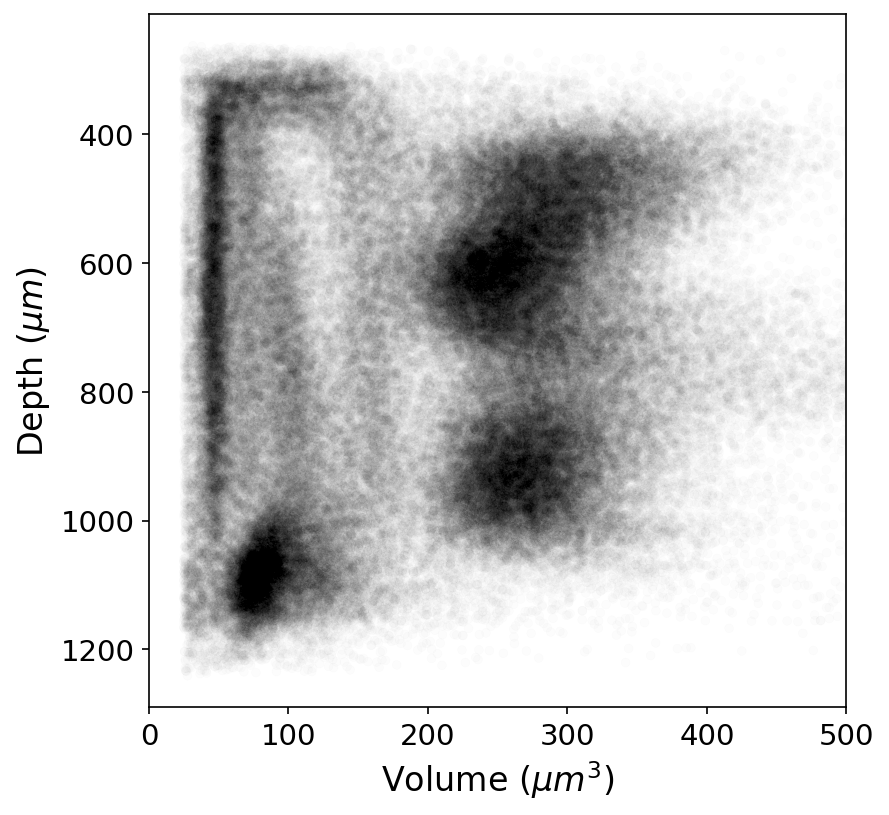

In [15]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.tick_params(labelsize=14)
sns.scatterplot(data=nucleus_df, x="volume", y="pt_position_y", size=1, edgecolor=None, alpha=.01, color="k", ax=ax, legend=False)
ax.invert_yaxis()
ax.set_xlabel("Volume ($\mu m^3$)", fontsize=16)
ax.set_ylabel("Depth ($\mu m$)", fontsize=16)
ax.set_xlim(0, 500)
plt.show()

### Qerying cell type information 

Identifying the putative ‘cell type’ from the EM morphology is a process that involves both manual and automatic classifications. Subsets of the dataset have been manually classified by anatomists at the Allen Institute, and these ground truth labels used to train and refine different automated ‘feature classifiers’ over time.

The diversity of manual and automated cell type classifications available in the dataset reflect the fact that definitions of ‘cell types’ in the dataset is an active area of research and must be contextualized against the purpose and resolution of the cell-typing being performed.

__Manual Cell Types (V1 Column)__

A subset of nucleus detections in a 100 um column (n=2204) in VISp were manually classified by anatomists at the Allen Institute into categories of cell subclasses, first distinguishing cells into classes of non-neuronal, excitatory and inhibitory. Excitatory cells were separated into laminar sub-classes (L23, L4), 3 sub-types of layer 5 cells (ET, IT, NP) and 2 classes of layer 6 cells (IT, CT). Inhibitory cells were classified into Bipolar (BPC), Basket (BC), Martinotti (MC), or Unsure (Unsure). Those neuronal calls are available from the CAVEclient under the table name `allen_v1_column_types_slanted_ref` which references the nucleus id of the cell.


Non-neuronal manual cells type calls enumerate astrocytes, microglia, pericytes, oligodendrocytes (oligo), and oligodendrocyte precursor cells (OPC), and area available in the table `aibs_column_nonneuronal_ref`.

In [16]:
manual_ct_df = client.materialize.query_table("allen_v1_column_types_slanted_ref", desired_resolution=[1000, 1000, 1000], split_positions=True,
                                       merge_reference=False)

print(len(manual_ct_df))
manual_ct_df.head(5)

1357


,id,created,superceded_id,valid,target_id,classification_system,cell_type
0,1,2023-03-18 14:13:21.577622+00:00,NaN,t,298945,aibs_coarse_excitatory,5P-IT
1,2,2023-03-18 14:13:21.578408+00:00,NaN,t,294715,aibs_coarse_excitatory,23P
2,3,2023-03-18 14:13:21.579093+00:00,NaN,t,264649,aibs_coarse_inhibitory,MC
3,4,2023-03-18 14:13:21.579790+00:00,NaN,t,294489,aibs_coarse_excitatory,23P
4,5,2023-03-18 14:13:21.580463+00:00,NaN,t,292708,aibs_coarse_excitatory,23P


__Automated Cell Type classification (Soma-nucleus model)__

Models were trained based upon the manual Column Neuron labels, as described in Elabbady et al. BioRxiv 2023. Each nucleus was analyzed for a variety of features, and a model trained on and independent dataset to distinguish neurons from non-neuronal detections. Non-neuron detections include both glial cells and false positive detections. The nucleus segmentation detected 171,818 connected components of nucleus objects, this model detected 82K neurons. Evaluation of this model on 1,316 cells in the volume shows the model has a recall of 99.6% for neurons, and a precision of 96.9%. All nucleus detections and the results of this model can be queried and linked to the cellular segmentation using the CAVEclient with the table name nucleus_neuron_svm.

Combining those features with the nucleus features we trained a hierachical model on the manual labels to predict cell-classes and sub-classes across a large number of neurons. This is available as CAVE table `aibs_metamodel_celltypes_v661`.

In [17]:
ct_df = client.materialize.query_table("aibs_metamodel_celltypes_v661", desired_resolution=[1000, 1000, 1000], split_positions=True,
                                       merge_reference=False)
print(len(ct_df))
ct_df.head(5)

94014


,id,created,superceded_id,valid,target_id,classification_system,cell_type
0,36916,2023-12-19 22:47:18.659864+00:00,NaN,t,336365,excitatory_neuron,5P-IT
1,1070,2023-12-19 22:38:00.472115+00:00,NaN,t,110648,excitatory_neuron,23P
2,1099,2023-12-19 22:38:00.898837+00:00,NaN,t,112071,excitatory_neuron,23P
3,13259,2023-12-19 22:41:14.417986+00:00,NaN,t,197927,nonneuron,oligo
4,13271,2023-12-19 22:41:14.685474+00:00,NaN,t,198087,nonneuron,astrocyte


Reference annotations contain `target_id` to merge them onto the table they target (here: the nucleus table). But do not worry, CAVE automatically merges them onto their target table by default (`merge_reference=True`):

In [18]:
ct_df = client.materialize.query_table("aibs_metamodel_celltypes_v661", desired_resolution=[1000, 1000, 1000], split_positions=True)

# remove segments with multiple cell bodies
ct_df = ct_df.drop_duplicates("pt_root_id", keep=False)
ct_df.head(5)

,id,created,valid,target_id,classification_system,cell_type,id_ref,created_ref,valid_ref,volume,...,pt_position_y,pt_position_z,bb_start_position_x,bb_start_position_y,bb_start_position_z,bb_end_position_x,bb_end_position_y,bb_end_position_z,pt_supervoxel_id,pt_root_id
0,36916,2023-12-19 22:47:18.659864+00:00,t,336365,excitatory_neuron,5P-IT,336365,2020-09-28 22:42:48.966292+00:00,t,272.488202,...,723.328,1083.04,NaN,NaN,NaN,NaN,NaN,NaN,93606511657924288,864691136274724621
1,1070,2023-12-19 22:38:00.472115+00:00,t,110648,excitatory_neuron,23P,110648,2020-09-28 22:45:09.650639+00:00,t,328.533443,...,518.528,1016.40,NaN,NaN,NaN,NaN,NaN,NaN,79385153184885329,864691135489403194
2,1099,2023-12-19 22:38:00.898837+00:00,t,112071,excitatory_neuron,23P,112071,2020-09-28 22:43:34.088785+00:00,t,272.929423,...,597.888,623.32,NaN,NaN,NaN,NaN,NaN,NaN,79035988248401958,864691136147292311
3,13259,2023-12-19 22:41:14.417986+00:00,t,197927,nonneuron,oligo,197927,2020-09-28 22:43:10.652649+00:00,t,91.308851,...,744.768,1058.84,NaN,NaN,NaN,NaN,NaN,NaN,84529699506051734,864691136050858227
4,13271,2023-12-19 22:41:14.685474+00:00,t,198087,nonneuron,astrocyte,198087,2020-09-28 22:41:36.677186+00:00,t,161.744978,...,763.776,1094.44,NaN,NaN,NaN,NaN,NaN,NaN,83756261929388963,864691135809440972


The reference table added two additional data columns: `classification_system` and `cell_type`. The `classification_system` divides the cells into excitatitory and inhibitory neurons as well as non-neuronal cells. `cell_type` provides lower level cell annotations.

In [19]:
ct_df["classification_system"].value_counts()

classification_system
excitatory_neuron    63757
nonneuron            18699
inhibitory_neuron     7847
Name: count, dtype: int64

In [20]:
ct_df["cell_type"].value_counts()

cell_type
23P          19642
4P           14720
6P-IT        11637
5P-IT         7889
astrocyte     7108
oligo         6900
6P-CT         6755
BC            3309
MC            2433
microglia     2394
5P-ET         2157
BPC           1484
OPC           1451
5P-NP          957
pericyte       846
NGC            621
Name: count, dtype: int64

### Location vs depth + Cell type


Because the cell type table contains the information about the nuclei, we can use it to plot the locations of all cell bodies as well and label them by type.

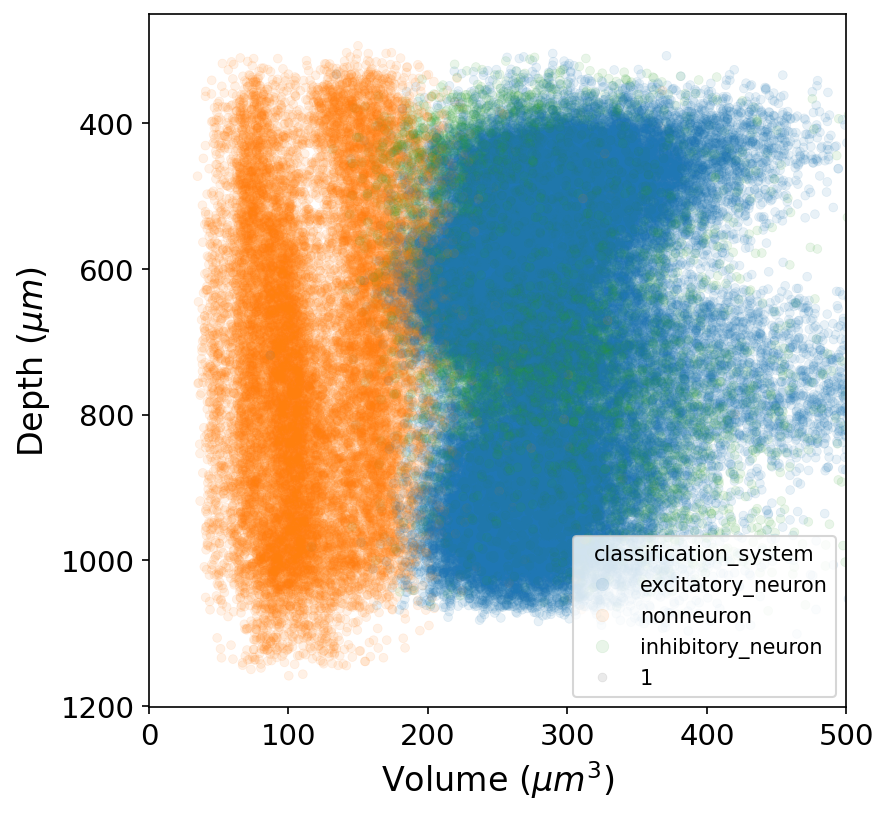

In [21]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.tick_params(labelsize=14)
sns.scatterplot(data=ct_df, x="volume", y="pt_position_y", size=1, edgecolor=None, alpha=.1, color="k", ax=ax, 
                legend=True, hue="classification_system")
ax.invert_yaxis()
ax.set_xlabel("Volume ($\mu m^3$)", fontsize=16)
ax.set_ylabel("Depth ($\mu m$)", fontsize=16)
ax.set_xlim(0, 500)
plt.show()

Soma volume is one of the distinguishing features used to classify cells into their morphological subtypes, and as expected this shows up in the plot of soma size by depth.

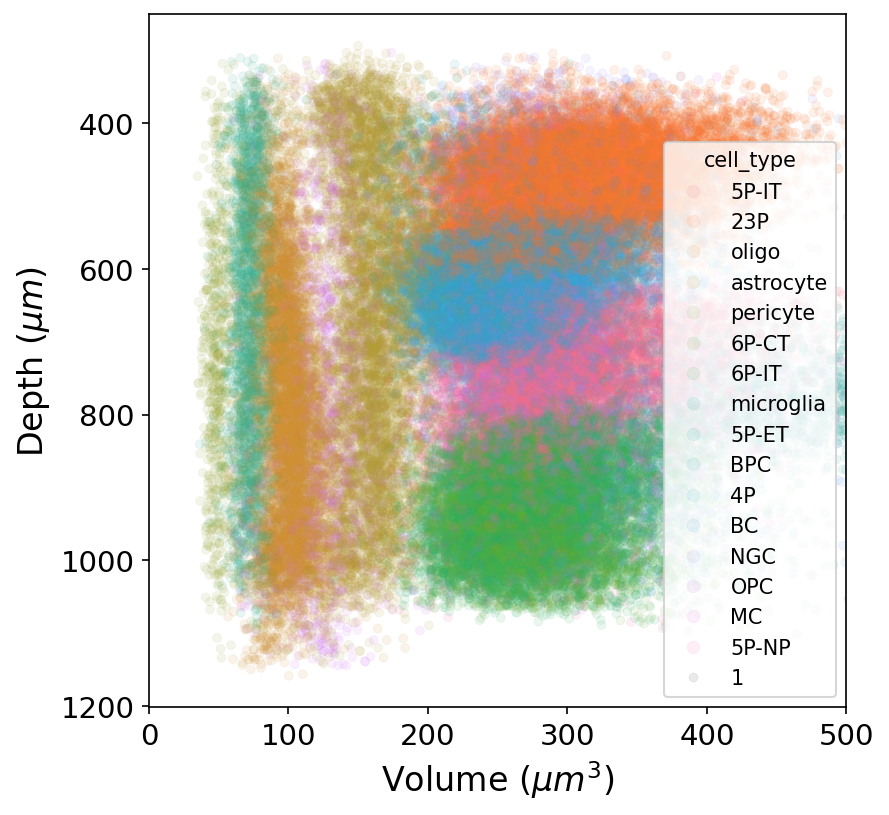

In [22]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)
ax.tick_params(labelsize=14)
sns.scatterplot(data=ct_df, x="volume", y="pt_position_y", size=1, edgecolor=None, alpha=.1, color="k", ax=ax, 
                legend=True, hue="cell_type")
ax.invert_yaxis()
ax.set_xlabel("Volume ($\mu m^3$)", fontsize=16)
ax.set_ylabel("Depth ($\mu m$)", fontsize=16)
ax.set_xlim(0, 500)
plt.show()

## Query 2: Proofread neurons

### Proofreading and data quality
Understanding this variablity in data quality is critical when interpretting the MICrONS data.

Automated segmentation of neuronal processes in dense EM imaging is challenging at the size of entire neurons, which can have millimeters of axons and dendrites. The automated segmentation algorithms used in the EM data for this project are not perfect, and so proofreading is necessary to obtain accurate reconstructions of a cell and confidence in the connectivity

In the MICrONS dataset, the general rule is that dendrites onto cells with a cell body are sufficiently proofread to trust synaptic connections onto a cell. Axons on the other hand require so much proofreading that only ~1,650 cells have proofread axons.

Axon and dendrite compartment status are marked separately, as proofreading effort was applied differently to the different compartments in some cells. In all cases, a status of TRUE indicates that false merges have been comprehensively removed, and the compartment is at least ‘clean’. Consult the ‘strategy’ column if completeness of the compartment is relevant to your research.

Some cells were extended to different degrees of completeness, or with different research goals in mind. This is denoted by 'strategy_axon', which may be one of:

* none: No cleaning, and no extension, and status is `FALSE`.
* axon_partially_extended: The axon was extended outward from the soma, following each branch to its termination. Output synapses represent a sampling of potential partners.
* axon_interareal: The axon was extended with a preference for branches that projected to other brain areas. Some axon branches were fully extended, but local connections may be incomplete. Output synapses represent a sampling of potential partners.
* axon_fully_extended: Axon was extended outward from the soma, following each branch to its termination. After initial extension, every endpoint was identified, manually inspected, and extended again if possible. Output synapses represent a largely complete sampling of partners.

In [23]:
proof_all_df = client.materialize.query_table("proofreading_status_and_strategy")

In [24]:
proof_all_df["strategy_axon"].value_counts()

strategy_axon
axon_partially_extended    1459
none                        149
axon_interareal             130
axon_fully_extended         127
Name: count, dtype: int64

In [25]:
proof_all_df["strategy_axon"].value_counts()

strategy_axon
axon_partially_extended    1459
none                        149
axon_interareal             130
axon_fully_extended         127
Name: count, dtype: int64

We can filter our query to only return rows that match a condition by adding a filter to our query:

In [26]:
proof_df = client.materialize.query_table("proofreading_status_and_strategy", filter_in_dict={"strategy_axon": ["axon_partially_extended", "axon_fully_extended", "axon_interareal"]})

In [27]:
proof_df["strategy_axon"].value_counts()

strategy_axon
axon_partially_extended    1459
axon_interareal             130
axon_fully_extended         127
Name: count, dtype: int64

For each neuron, the complete changelog is available (takes ~10s):

In [28]:
client.chunkedgraph.get_tabular_change_log(864691135617152361)[864691135617152361]

,operation_id,timestamp,user_id,before_root_ids,after_root_ids,is_merge,user_name,user_affiliation
16,14048,1594957819802,161,"[864691135098889083, 864691135430732018]",[864691135758465614],True,Forrest Collman,
45,45786,1595367940909,121,[864691135758465614],[864691135212632448],False,Forrest Collman,Collman
84,103327,1597331610449,84,[864691135212632448],[864691135866473238],False,Merlin Moore,"Mala Murthy Lab, Sebastian Seung Lab"
85,103343,1597331855913,84,[864691135866473238],[864691135939453441],False,Merlin Moore,"Mala Murthy Lab, Sebastian Seung Lab"
86,103355,1597331954262,84,[864691135939453441],"[864691135700311931, 864691135782441779]",False,Merlin Moore,"Mala Murthy Lab, Sebastian Seung Lab"
...,...,...,...,...,...,...,...,...
2692,948262,1713998356792,2653,"[864691134770935733, 864691135889957513]",[864691136117452452],True,Chi Zhang,
2693,948263,1713998361999,2653,"[864691135940791041, 864691136117452452]",[864691135940791297],True,Chi Zhang,
2694,948264,1713998376631,2653,"[864691135835840648, 864691135940791297]",[864691135383744730],True,Chi Zhang,
2695,948265,1713998386112,2653,"[864691135374968649, 864691135383744730]",[864691135763156534],True,Chi Zhang,


## Query 3: Synapse query

The MICrONS dataset relies on automatically detected synapses for connectivity information. The consortium automatically detected and associated a total of 337 million synaptic clefts. The detections were evaluated by manually identifying synapses in 70 small subvolumes (n=8,611 synapses) distributed across the dataset, giving the automated detection an estimated precision of 96% and recall of 89% with a partner assignment accuracy of 98%.

We can query the synapse table directly. However, it is too large to query all at once. CAVE limits to queries to 500,000 rows at once and will display a warning when that happens. Here, we demonstrate this with the limit set to 10:

In [29]:
synapse_table_name = client.info.get_datastack_info()["synapse_table"]
syn_df = client.materialize.query_table(synapse_table_name, limit=10)
syn_df

201 - "Limited query to 10 rows


,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position
0,482324897,2020-11-04 06:48:58.343057+00:00,NaN,t,2976,115495518947404152,864691135035312593,115495450227928501,864691134965890572,"[369112, 212714, 15509]","[369072, 212594, 15510]","[369048, 212662, 15509]"
1,111356912,2020-11-04 06:48:58.343057+00:00,NaN,t,2976,85086257273159206,864691135557293342,85086257339729644,864691137053640566,"[147796, 138764, 16897]","[147776, 138852, 16899]","[147788, 138800, 16900]"
2,219362361,2020-11-04 06:48:58.343057+00:00,NaN,t,2976,94513263810944271,864691135595450728,94513195091453796,864691135204272683,"[216374, 120622, 16558]","[216228, 120512, 16548]","[216298, 120572, 16550]"
3,350226388,2020-11-04 06:48:58.343057+00:00,NaN,t,2976,105064109745413552,864691136216863455,105064109745412680,864691136774161774,"[293326, 87422, 24824]","[293310, 87362, 24820]","[293308, 87404, 24821]"
4,292350246,2020-11-04 06:48:58.343057+00:00,NaN,t,2976,100140703036155312,864691135628516419,100140703036140569,864691132041695465,"[257344, 105256, 26480]","[257308, 105334, 26472]","[257334, 105320, 26476]"
5,164940667,2020-11-04 06:48:58.343057+00:00,NaN,t,2976,89801650193255101,864691135375598409,89801650193247746,864691136175511558,"[182246, 143776, 15510]","[182258, 143726, 15501]","[182268, 143706, 15510]"
6,261934954,2020-11-04 06:48:58.343057+00:00,NaN,t,2976,97759091191496793,864691136296744475,97759091258050193,864691135404420078,"[240128, 186772, 19453]","[240150, 186890, 19460]","[240150, 186838, 19457]"
7,47809213,2020-11-04 06:48:58.343057+00:00,NaN,t,2976,80029534644397607,864691135585163343,80029534644408014,864691135379785202,"[110872, 212138, 17110]","[110962, 212128, 17115]","[110894, 212124, 17111]"
8,65519860,2020-11-04 06:48:58.343057+00:00,NaN,t,5960,81992645077294792,864691136156246677,81992645077283850,864691136817302638,"[125058, 158400, 25982]","[125106, 158336, 25974]","[125095, 158362, 25977]"
9,446835682,2020-11-04 06:48:58.343057+00:00,NaN,t,2976,112953654491063415,864691136538026146,112953654491055747,864691134020263786,"[350384, 149072, 17717]","[350436, 149024, 17718]","[350412, 149034, 17713]"


Instead we need to limit our query to a few neurons. We can query the graph spanned by the neurons with "clean" axons using the `filter_in_dict` parameter:

Note: this will take 1-2 min to collect the synapses

In [30]:
%%time 

synapse_table_name = client.info.get_datastack_info()["synapse_table"]
syn_df = client.materialize.query_table(synapse_table_name, 
                                        filter_in_dict={"pre_pt_root_id": proof_df["pt_root_id"], 
                                                        "post_pt_root_id": proof_df["pt_root_id"]})

# remove autapses (which are usually false detections. Real autapses are very rare)
syn_df = syn_df[syn_df["pre_pt_root_id"] != syn_df["post_pt_root_id"]]
syn_df

CPU times: total: 609 ms
Wall time: 15.5 s


,id,created,superceded_id,valid,size,pre_pt_supervoxel_id,pre_pt_root_id,post_pt_supervoxel_id,post_pt_root_id,pre_pt_position,post_pt_position,ctr_pt_position
0,152094175,2020-11-04 07:20:36.943498+00:00,NaN,t,14020,88401010355440214,864691135778700477,88401010355435596,864691135561699041,"[171952, 194076, 19787]","[171996, 194038, 19786]","[172002, 194074, 19793]"
2,174979485,2020-11-04 08:50:39.220791+00:00,NaN,t,4688,90161191099360974,864691136057875416,90161191099310671,864691136674495623,"[184770, 200984, 19986]","[184786, 201052, 19972]","[184816, 200974, 19981]"
3,144648847,2020-11-04 10:25:21.607615+00:00,NaN,t,5720,87827409285525264,864691136389688695,87827409285520659,864691136143786292,"[167926, 114800, 22586]","[167920, 114768, 22583]","[167926, 114776, 22585]"
4,169522283,2020-11-04 10:04:52.156660+00:00,NaN,t,3324,89740421676702924,864691136057875416,89740421676693506,864691135430186032,"[181746, 211838, 19942]","[181744, 211894, 19941]","[181730, 211872, 19943]"
5,162136447,2020-11-04 08:59:31.152894+00:00,NaN,t,2252,89245023035545401,864691135838411155,89245023035536572,864691136057875416,"[177812, 190936, 20004]","[177814, 190878, 20007]","[177812, 190902, 20004]"
...,...,...,...,...,...,...,...,...,...,...,...,...
181958,203507823,2020-11-04 10:11:13.597358+00:00,NaN,t,3296,92762773251190110,864691135517447891,92692404507007302,864691136437883550,"[203298, 185672, 21739]","[203266, 185770, 21742]","[203290, 185716, 21738]"
181959,166395590,2020-11-04 09:12:49.205306+00:00,NaN,t,6496,89525398769305088,864691136674556295,89525398769283786,864691136437883550,"[180072, 182912, 22272]","[180040, 182880, 22265]","[180055, 182951, 22269]"
181960,167525342,2020-11-04 08:48:35.679627+00:00,NaN,t,4768,89595217690536025,864691136674556295,89595217690524092,864691136437883550,"[180490, 178654, 21756]","[180414, 178598, 21741]","[180469, 178590, 21747]"
181963,112184560,2020-11-04 13:50:49.701162+00:00,NaN,t,1240,85512250248545880,864691135571546917,85512250248542305,864691136437883550,"[150658, 166810, 23655]","[150716, 166818, 23650]","[150729, 166875, 23651]"


### Connectivity matrix: binary connectivity

Compared to the nucleus table, the synapse table has two points which were associated with segments (`pre_pt_position` and `post_pt_position`). The associated root ID columns are `pre_pt_root_id` and `post_pt_root_id`. 

Using pandas pivot function, we can transform this table into a matrix and plot it:

In [31]:
# collect the count of synapse connectivity
syn_mat = syn_df.pivot_table(index="pre_pt_root_id", columns="post_pt_root_id", 
                             values="size", aggfunc=lambda x: float(np.sum(x) > 0)).fillna(0)

# Squaring the matrix
syn_mat = syn_mat.reindex(columns=syn_mat.index)

<Axes: xlabel='pre_pt_root_id', ylabel='pre_pt_root_id'>

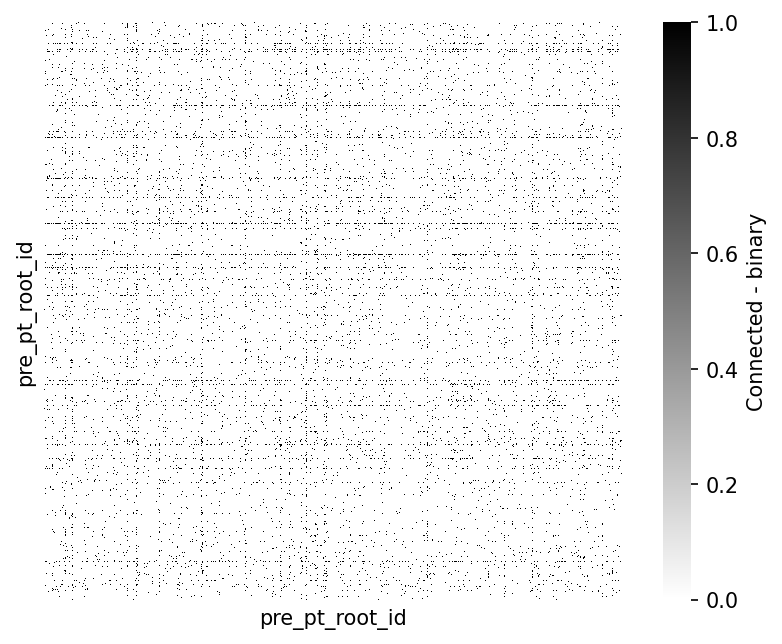

In [32]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=150)
sns.heatmap(syn_mat, cmap="gray_r", xticklabels=[], yticklabels=[], 
            ax=ax, square=True,
            cbar_kws={"label": "Connected - binary"})

### Connectivity matrix: aggregate synapse size

Depending on your model of connectivity, you may want to take take __synapse size and number__ into account. The `size` column of the synapse table in the in the MICrONS dataset measure the synaptic cleft volume annotated by the automated classifier in voxels (3d pixels). These are correlated to anatomical measures such as synaptic area and spine head volumes (for excitatory synapses). Let's replot the square matrix with the aggregate sum of synapses sizes between each connected pair.

In [33]:
# aggregate sum of synapse size
syn_mat = syn_df.pivot_table(index="pre_pt_root_id", columns="post_pt_root_id", values="size", aggfunc="sum")

# Squaring the matrix
syn_mat = syn_mat.reindex(columns=syn_mat.index)

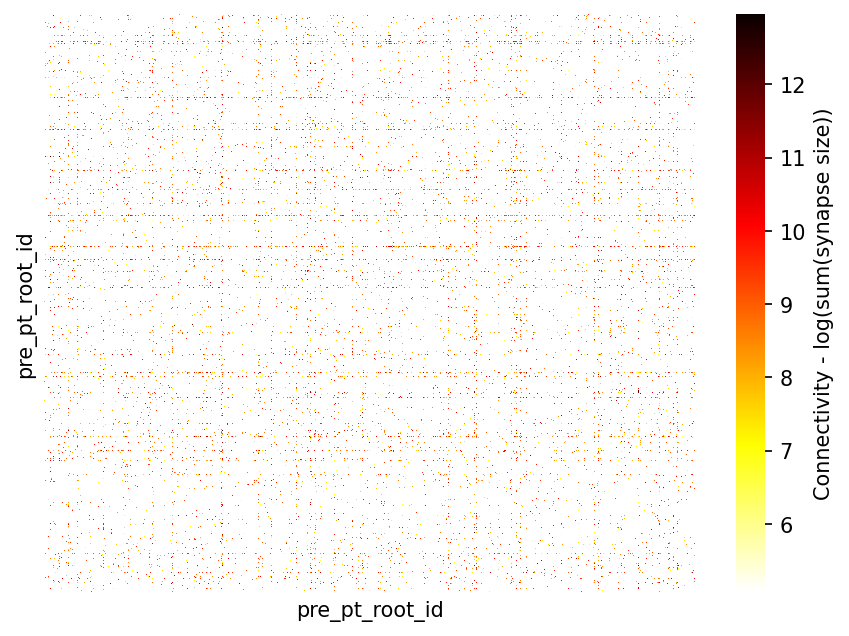

In [34]:
fig, ax = plt.subplots(figsize=(7, 5), dpi=150)
sns.heatmap(np.log(syn_mat), cmap="hot_r", ax=ax, xticklabels=[], yticklabels=[], cbar_kws={"label": 'Connectivity - log(sum(synapse size))'})
plt.show()

## Conclusions
There is structure between different connected pairs, but without more information about the individual rows or columns it can be difficult to interpret one. 

One next step is to combine the __cell type information__ and __output connectivity__ to explain the connectivity patterns